In [12]:
# Libraries
using ScikitLearn;
using DataFrames;
using CSV;
using Random;
using Statistics;
using StatsPlots;
using Flux.Losses;
using Flux;

@sk_import impute: KNNImputer; # Imputation of missing values.
@sk_import svm: SVC;
@sk_import decomposition: PCA;
@sk_import tree: DecisionTreeClassifier;
@sk_import neighbors: KNeighborsClassifier;

include("utils/fluxANNs.jl"); # for ANN training with Flux
include("utils/evaluation.jl"); # for confusion matrix calculation and cross validation set partitioning
include("utils/preprocessing.jl"); # for normalization, one-hot encoding, holdout division
include("utils/training.jl"); # for crossvalidation methodology
include("utils/visualizations.jl"); # for plots

# Set seed
Random.seed!(10);

# Hold-out partition

In [2]:
# loading the dataset
support2 = CSV.read("datasets/support2_cleaned.csv", DataFrame, delim = ',');

# fate: 0 = recovery, 1 = death at home, 2 = death at the hospital
support2[:, "fate"] = support2[:,"death"] + support2[:,"hospdead"];
target_cols = ["death", "hospdead", "fate"];

trainIndex, testIndex = holdOut(nrow(support2), 0.2);

trainInputs = Array(support2[trainIndex, Not(target_cols)]);
testInputs = Array(support2[testIndex, Not(target_cols)]);

# Imputation

In [3]:
imputer = KNNImputer(n_neighbors = 5);

trainInputs[:,1:32] = fit_transform!(imputer, trainInputs[:,1:32]);
testInputs[:,1:32] = imputer.transform(testInputs[:,1:32]);

# Visualizations

In [10]:
meanTrain, stdTrain = calculateZeroMeanNormalizationParameters(trainInputs[:,1:32]);
numInputs = normalizeZeroMean!(trainInputs[:,1:32], (meanTrain, stdTrain));

plot_correlations(numInputs);
savefig("plots/correlations.png");

# Train PCA on training dataset.
pca = PCA(2);
pcaInputs = fit_transform!(pca, numInputs);

# Draw results
draw_results(pcaInputs, trainTargets; colors=[:green,:red], target_names=["Survived", "Died"]);
savefig("plots/pca.png");

# Helper function for finding best performing model

In [4]:
function findBestModel(models, trainInputs, trainTargets, kFoldIndices)
    bestMetricYet = 0;
    bestModel = -1;
    
    for (modelType, paramList) in models
        cnt = 1;
        println();
        println("Training ", modelType, " models:");
        for params in paramList
            (accur, fScore), (stdAccur, stdFScore) = modelCrossValidation(modelType, params, trainInputs,
                                                                          trainTargets, kFoldIndices);
            println("Configuration ", cnt, ": ", params);
            println("Accuracy:", accur, ", stdDev:", stdAccur);
            println("F1-Score:", fScore, ", stdDev:", stdFScore);
            println();
            cnt += 1;
            #println(modelType, (accur, fScore), (stdAccur, stdFScore))
            if accur * fScore > bestMetricYet
                bestMetricYet = accur * fScore;
                bestModel = (modelType, params);
            end;
        end;
    end;
    
    return bestModel
end;

# Binary approach

In [5]:
trainTargets = Array(support2[trainIndex, "death"]);
testTargets = Array(support2[testIndex, "death"]);

# for categorical approach
# trainTargets = Array(support2[trainIndex, "fate"]);
# testTargets = Array(support2[testIndex, "fate"]);

# Kfold
kFoldIndices = crossvalidation(trainTargets, 5);

trainedEnsemble = false

false

- ANN

In [9]:
ANNparams = [Dict("topology" => [2], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [4], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [8], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [16], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [2, 2], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [4, 4], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [8, 8], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [16, 16], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1)]

models = [(:ANN, ANNparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training ANN models:


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(10 => 2, σ)   # 22 parameters
│   summary(x) = "10×5202 adjoint(::Matrix{Float64}) with eltype Float64"
└ @ Flux ~/.julia/packages/Flux/hiqg1/src/layers/stateless.jl:60


Configuration 1: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [2], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)
Accuracy:0.873416881326332, stdDev:0.005120544704601835
F1-Score:0.9041668359990285, stdDev:0.0033668697275526334

Configuration 2: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [4], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)
Accuracy:0.873320129279825, stdDev:0.006564360670351429
F1-Score:0.9041973619522736, stdDev:0.0042325322570128925

Configuration 3: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [8], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)
Accuracy:0.8728634486257281, stdDev:0.006535735506352692
F1-Score:0.903877594122676, stdDev:0.004362561210048207

Configuration 4: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [16], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)

- SVM

In [8]:
SVMparams = [Dict("kernel" => "linear", "degree" => 0, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "linear", "degree" => 0, "gamma" => "scale", "C" => 1),
            Dict("kernel" => "rbf", "degree" => 0, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "rbf", "degree" => 0, "gamma" => "scale", "C" => 1),
            Dict("kernel" => "sigmoid", "degree" => 0, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "sigmoid", "degree" => 0, "gamma" => "scale", "C" => 1),
            Dict("kernel" => "poly", "degree" => 3, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "poly", "degree" => 3, "gamma" => "scale", "C" => 1)]

models = [(:SVM, SVMparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training SVM models:
Configuration 1: Dict{String, Any}("C" => 0.1, "kernel" => "linear", "gamma" => "scale", "degree" => 0)
Accuracy:0.8667325912161559, stdDev:0.00921074610941897
F1-Score:0.859347099809287, stdDev:0.05682470000058078

Configuration 2: Dict{String, Any}("C" => 1, "kernel" => "linear", "gamma" => "scale", "degree" => 0)
Accuracy:0.8677009704922323, stdDev:0.008513523763343082
F1-Score:0.859621042141321, stdDev:0.05802406972489269

Configuration 3: Dict{String, Any}("C" => 0.1, "kernel" => "rbf", "gamma" => "scale", "degree" => 0)
Accuracy:0.8714378047358879, stdDev:0.004782239415350677
F1-Score:0.8651940371830156, stdDev:0.0519361753753832

Configuration 4: Dict{String, Any}("C" => 1, "kernel" => "rbf", "gamma" => "scale", "degree" => 0)
Accuracy:0.8778027686300971, stdDev:0.0053148635498719435
F1-Score:0.8720369451170311, stdDev:0.049109549460325905

Configuration 5: Dict{String, Any}("C" => 0.1, "kernel" => "sigmoid", "gamma" => "scale", "degree" => 0)
Accuracy:0.83

- DecisionTree

In [6]:
DTreeParams = [Dict("maxDepth" => 4), Dict("maxDepth" => 8), Dict("maxDepth" => 16),
                Dict("maxDepth" => 32), Dict("maxDepth" => 64), Dict("maxDepth" => 128)]

models = [(:DTree, DTreeParams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training DTree models:
Configuration 1: Dict("maxDepth" => 4)
Accuracy:0.8870752664856216, stdDev:0.003898496394635204
F1-Score:0.8851105148402878, stdDev:0.034749381284964555

Configuration 2: Dict("maxDepth" => 8)
Accuracy:0.8845819045392191, stdDev:0.0036037883699533194
F1-Score:0.879656954481885, stdDev:0.04523540199374454

Configuration 3: Dict("maxDepth" => 16)
Accuracy:0.858289585476798, stdDev:0.01129636499514417
F1-Score:0.8512554150628467, stdDev:0.06111273140926431

Configuration 4: Dict("maxDepth" => 32)
Accuracy:0.8517854477988143, stdDev:0.006986882938653191
F1-Score:0.8414994418545101, stdDev:0.07036619186454351

Configuration 5: Dict("maxDepth" => 64)
Accuracy:0.8517854477988143, stdDev:0.006986882938653191
F1-Score:0.8414994418545101, stdDev:0.07036619186454351

Configuration 6: Dict("maxDepth" => 128)
Accuracy:0.8517854477988143, stdDev:0.006986882938653191
F1-Score:0.8414994418545101, stdDev:0.07036619186454351

Best model is DTree with hyperparameters:
Dict("maxDep

- KNN

In [7]:
KNNparams = [Dict("k" => 3), Dict("k" => 6), Dict("k" => 12),
            Dict("k" => 24), Dict("k" => 48), Dict("k" => 96)]

models = [(:KNN, KNNparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");

println(params);


Training KNN models:
Configuration 1: Dict("k" => 3)
Accuracy:0.8512321012046857, stdDev:0.006195018143799913
F1-Score:0.8426534914953482, stdDev:0.06523032291306964

Configuration 2: Dict("k" => 6)
Accuracy:0.8627188454408914, stdDev:0.003860727943349614
F1-Score:0.8582969709610706, stdDev:0.04989191322528688

Configuration 3: Dict("k" => 12)
Accuracy:0.8679769261690465, stdDev:0.006170164761432945
F1-Score:0.8613977194684344, stdDev:0.05375789484316565

Configuration 4: Dict("k" => 24)
Accuracy:0.8701919384267243, stdDev:0.0049463984508814835
F1-Score:0.8645095238114765, stdDev:0.0506764005228833

Configuration 5: Dict("k" => 48)
Accuracy:0.8681177290157492, stdDev:0.00796542662675591
F1-Score:0.8623064999230264, stdDev:0.051438652577348976

Configuration 6: Dict("k" => 96)
Accuracy:0.8659011838109167, stdDev:0.006224442990402406
F1-Score:0.8593231991705444, stdDev:0.054814125967934064

Best model is KNN with hyperparameters:
Dict("k" => 24)


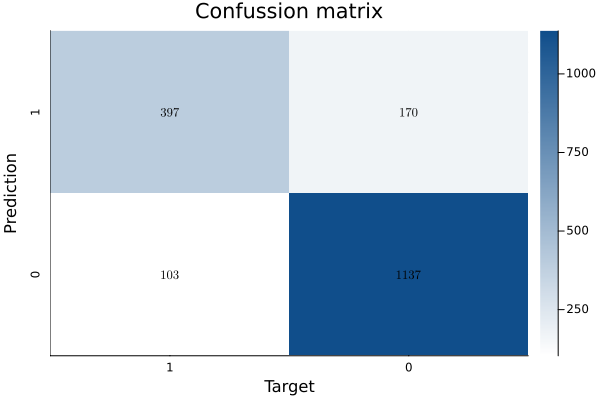

In [40]:
using Plots;

# train best model with all paterns and build confusion matrix with all patterns
train = (trainInputs, trainTargets); test = (testInputs, testTargets);

# normalization and validation set computation if needed
valRatio = if modelType != :ANN 0. else params["validationRatio"] end
train, val, test = prepareDataForFitting(train, test, valRatio)

classes = unique(trainTargets)
matAndMetrics = fitAndConfusion(modelType, params, train, val, test, classes)
confMat = matAndMetrics[8]

function displayConfMat(confMat, classes)
    (n,m) = size(confMat)
    heatmap(confMat, fc=cgrad([:white,:dodgerblue4]), xticks=(1:m,classes), yrot=90, yticks=(1:m,classes), 
            title="Confussion matrix", xlabel="Target", ylabel="Prediction", yflip=true)
    # add number of coincidences in each cell
    annotate!([(j, i, text(round(confMat[i,j]), 8,"Computer Modern",:black)) for i in 1:n for j in 1:m])
end

displayConfMat(confMat, classes)

- Ensemble

In [10]:
@sk_import ensemble:StackingClassifier

# An ANN flux model cannot be included in a Scikit ensemble due to PyCall wrapping issues
estimators = [:KNN, :DTree, :SVM]
params = []
DTreeParams = Dict("maxDepth" => 4)
KNNparams = Dict("k" => 24)
SVMparams = Dict("C" => 1, "kernel" => "rbf", "gamma" => "scale", "degree" => 0)


params = Vector{Dict}([KNNparams, DTreeParams, SVMparams])

means, stds = trainClassEnsemble(estimators, params, (trainInputs, trainTargets),
                   crossvalidation(trainTargets, 5))

println("Mean accuracy and F-Score: ", means)
println("Standard deviations in accuracy and F-Score: ", stds)

Mean accuracy and F-Score: 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x78af7eb4fce0>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

[0.6793524059905873 0.48537291733894944]
Standard deviations in accuracy and F-Score: [0.00023506076675358387 0.44308283187052994]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x78af7eb8d080>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

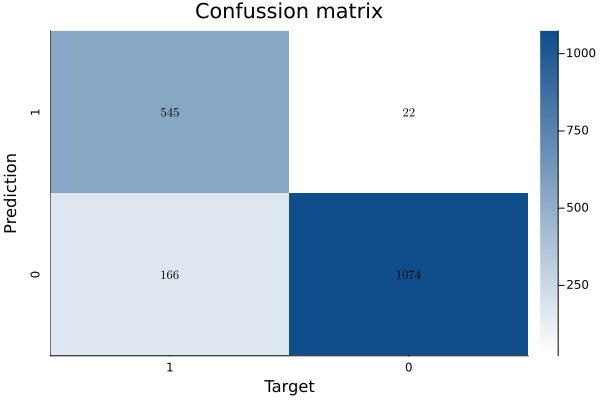

In [11]:
using Plots;

# train best model with all paterns and build confusion matrix with all patterns
train = (trainInputs, trainTargets); test = (testInputs, testTargets);

ensemble = fitEnsemble(train, estimators, params)

classes = unique(trainTargets)
matAndMetrics = confusionMatrix(predict(ensemble, testInputs), testTargets; weighted=true)
confMat = matAndMetrics[8]

function displayConfMat(confMat, classes)
    (n,m) = size(confMat)
    heatmap(confMat, fc=cgrad([:white,:dodgerblue4]), xticks=(1:m,classes), yrot=90, yticks=(1:m,classes), 
            title="Confussion matrix", xlabel="Target", ylabel="Prediction", yflip=true)
    # add number of coincidences in each cell
    annotate!([(j, i, text(round(confMat[i,j]), 8,"Computer Modern",:black)) for i in 1:n for j in 1:m])
end

displayConfMat(confMat, classes)

In [ ]:
# models = [(:KNN, KNNparams),(:DTree, DTreeParams),(:SVM, SVMparams),(:ANN, ANNparams)]